<a href="https://colab.research.google.com/github/Ahbar1999/mtp-pimsimulator/blob/main/pimsimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [13]:
class PIMSimulator:
    def __init__(self, num_crossbars=1024, crossbar_size=(128, 128), bits_per_cell=1, weight_bits=8, wear_levelling_enabled=True):
        self.num_crossbars = num_crossbars
        self.crossbar_rows, self.crossbar_cols = crossbar_size
        self.bits_per_cell = bits_per_cell
        # (quantization)bits per weight
        self.weight_bits = weight_bits
        self.wear_levelling_enabled = wear_levelling_enabled

        # Calculate how many weights fit in one crossbar
        self.cells_per_crossbar = self.crossbar_rows * self.crossbar_cols
        self.weights_per_crossbar = self.cells_per_crossbar // self.weight_bits

        # interval write counters for each crossbar
        self.iwc_counters = np.zeros(num_crossbars, dtype=np.uint32)
        # total write counters for each crossbar
        self.twc_counters = np.zeros(num_crossbars, dtype=np.uint64)

        # addressing granularity is a crossbar
        # LAID -> PAID: Both IDs start from 0
        self.access_count = 0                   # memory acesses
        self.access_count_for_rows = 0
        self.remapping_interval = 1000

        self.tensor_registry = {}           # tensor_name -> segment_list
        # the following map should be changed to xbar_base_addr -> xbar_object
        # the crossbar object will have an address field
        self.laid_to_paid_map = {}          # logical to physical xbar ids
        self.next_laid = 0                  # next free LAID(that maps to physical id)
        self.next_physical_crossbar = 0     # next free PAID(of the actual crossbar)

        # row mapping code
        # write count 2D array for xbar * rows
        self.row_write_counts = np.zeros((num_crossbars, self.crossbar_rows), dtype=np.int64)
        self.row_mappings = [list(range(self.crossbar_rows)) for _ in range(num_crossbars)]

        print(f"Crossbar config: {crossbar_size}, {self.weights_per_crossbar} weights per crossbar")

    def register_model(self, model):
        """Build collision-free mapping for all tensors once"""
        for name, param in model.named_parameters():
            # generate mapping for trainable parameters
            if param.requires_grad:
                segments = self._partition_tensor(name, param)
                self.tensor_registry[name] = segments

    def _partition_tensor(self, tensor_name, tensor):
        """Assign non-overlapping LAIDs and PAIDs"""
        tensor_size = tensor.numel()
        crossbars_needed = math.ceil(tensor_size / self.weights_per_crossbar)

        segments = []
        remaining_elements = tensor_size

        for i in range(crossbars_needed):
            laid = self.next_laid
            paid = self.next_physical_crossbar % self.num_crossbars

            elements = min(remaining_elements, self.weights_per_crossbar)

            segments.append({
                'laid': laid,
                'paid': paid,
                'elements': elements,
                'logical_offset': tensor_size - remaining_elements
            })

            # Map LAID to initial PAID
            self.laid_to_paid_map[laid] = paid

            self.next_laid += 1
            self.next_physical_crossbar += 1
            remaining_elements -= elements

        return segments

    '''
    def map_tensor_to_crossbars(self, tensor):
        """Map tensor elements to multiple crossbars based on actual capacity"""
        tensor_size = tensor.numel()  # Total number of elements

        # Calculate how many crossbars this tensor spans
        crossbars_needed = math.ceil(tensor_size / self.weights_per_crossbar)

        # Generate crossbar mapping based on tensor's memory address
        base_crossbar = hash(tensor.data_ptr()) % self.num_crossbars

        crossbar_mappings = []
        remaining_elements = tensor_size

        for i in range(crossbars_needed):
            crossbar_id = (base_crossbar + i) % self.num_crossbars
            physical_crossbar = self.mapping_table.get(crossbar_id, crossbar_id)

            # Calculate how many elements go to this crossbar
            elements_in_crossbar = min(remaining_elements, self.weights_per_crossbar)

            crossbar_mappings.append({
                'crossbar_id': physical_crossbar,
                'elements': elements_in_crossbar,
                'utilization': elements_in_crossbar / self.weights_per_crossbar
            })

            remaining_elements -= elements_in_crossbar

        return crossbar_mappings
    '''

    def log_memory_access(self, tensor_name, is_write=True, operation="unknown"):
        """Accurate logging considering tensor size and crossbar capacity"""
        if not is_write or tensor_name not in self.tensor_registry:
            return

        xbars = self.tensor_registry[tensor_name]

        for xbar in xbars:
            laid = xbar['laid']
            current_paid = self.laid_to_paid_map[laid]  # address translation
            elements = xbar['elements']

            writes_per_element = self.weight_bits // self.bits_per_cell
            total_writes = elements * writes_per_element

            # record interval write count for current xbar
            self.iwc_counters[current_paid] += total_writes

            self._log_row_level_writes(current_paid, elements, total_writes)

        self.access_count += 1
        self.access_count_for_rows += 1

        if self.access_count % self.remapping_interval == 0:
            self.perform_remapping()

        if self.access_count_for_rows >= self.remapping_interval == 0:
            self.perform_row_remapping()
            self.access_count_for_rows = 0

    def _log_row_level_writes(self, crossbar_id, elements, total_writes):
        weights_per_row = self.crossbar_cols * (self.bits_per_cell // self.weight_bits)
        if weights_per_row <= 0:
            weights_per_row = self.crossbar_cols // 8  # Fallback: assume 8-bit weights

        rows_affected = math.ceil(elements / weights_per_row)
        writes_per_row = total_writes // rows_affected if rows_affected > 0 else total_writes

        for logical_row in range(min(rows_affected, self.crossbar_rows)):
            physical_row = self.row_mappings[crossbar_id][logical_row]
            self.row_write_counts[crossbar_id][physical_row] += writes_per_row

    def perform_row_remapping(self):
        """Perform new swapping within crossbars to balance row-level wear"""
        """Swaps 2 highest and lowest utilized rows in xbars"""
        print("Performing Row Remapping...")
        total_swaps =0

        for crossbar_id in range(self.num_crossbars):
          row_counts = self.row_write_counts[crossbar_id]

          if np.sum(row_counts) == 0:
            continue

          max_wear_physical = np.argmax(row_counts)
          min_wear_physical = np.argmin(row_counts)

          if min_wear == 0 or (max_wear / min_wear) < self.row_swap_threshold:
            continue

          max_logical = self.row_mappings[crossbar_id].index(max_wear_physical)
          min_logical = self.row_mappings[crossbar_id].index(min_wear_physical)

          self.row_mappings[crossbar_id][max_logical] = min_wear_physical
          self.row_mappings[crossbar_id][min_logical] = max_wear_physical

          total_swap += 1

          # Optional: Log the swap
          if self.access_count % (self.row_swap_interval * 10) == 0:  # Log occasionally
            print(f"Row swap in crossbar {crossbar_id}: "
                  f"logical {max_logical}→physical {min_wear_physical}, "
                  f"logical {min_logical}→physical {max_wear_physical} "
                  f"(wear ratio: {max_wear/min_wear:.2f})")

          return total_swaps

    def perform_remapping(self):
        print("Performing Remapping...")
        # print(f"Old mapping: {self.laid_to_paid_map}")

        # Update Total Wear Count (TWC)
        for laid, iwc in enumerate(self.iwc_counters):
            paid = self.laid_to_paid_map.get(laid, laid)
            self.twc_counters[paid] += iwc
            self.iwc_counters[laid] = 0  # Reset interval counter

        if not self.wear_levelling_enabled:
            print("wear levelling has been disabled!")
            return
        # Sort crossbars by wear level (TWC)
        wear_sorted_crossbars = sorted(enumerate(self.twc_counters), key=lambda x: x[1])

        # Sort logical crossbars by hotness (recent writes)
        hotness_sorted = sorted(enumerate(self.iwc_counters), key=lambda x: x[1], reverse=True)

        # Rebuild mapping: hottest logical → coolest physical
        new_mapping = {}
        # (hot laid, hotness value)
        for i, (hot_laid, _) in enumerate(hotness_sorted):
            cool_paid, _ = wear_sorted_crossbars[i]  # Least worn physical crossbar
            new_mapping[hot_laid] = cool_paid

        # print("change in mappings: ")
        # for laid in new_mapping:
        #   if self.laid_to_paid_map[laid] != new_mapping[laid]:
        #     print(f"{laid}: {self.laid_to_paid_map[laid]} -> {new_mapping[laid]}")

        self.laid_to_paid_map = new_mapping
        # print(f"New mapping: {self.laid_to_paid_map}")

    def get_crossbar_utilization_stats(self):
        """Analyze crossbar utilization patterns"""
        stats = {
            'total_crossbars': self.num_crossbars,
            'weights_per_crossbar': self.weights_per_crossbar,
            'active_crossbars': np.count_nonzero(self.iwc_counters),
            'avg_wear': np.mean(self.twc_counters),
            'max_wear': np.max(self.twc_counters),
            'wear_imbalance': np.max(self.twc_counters) / (np.min(self.twc_counters) + 1)
        }
        return stats


    def get_row_wear_statistics(self):
      """Get comprehensive row-level wear statistics"""
      active_crossbars = np.sum(self.row_write_counts, axis=1) > 0
      active_crossbar_count = np.sum(active_crossbars)

      if active_crossbar_count == 0:
          return {
              'max_row_wear': 0,
              'min_row_wear': 0,
              'avg_row_wear': 0,
              'row_wear_imbalance': 1.0,
              'active_crossbars': 0
          }

      # Get row wear stats across all active crossbars
      active_row_counts = self.row_write_counts[active_crossbars]
      all_row_wear = active_row_counts.flatten()
      active_row_wear = all_row_wear[all_row_wear > 0]

      return {
          'max_row_wear': all_row_wear.max(),
          'min_row_wear': active_row_wear.min() if len(active_row_wear) > 0 else 0,
          'avg_row_wear': active_row_wear.mean() if len(active_row_wear) > 0 else 0,
          'row_wear_imbalance': all_row_wear.max() / (active_row_wear.min() + 1) if len(active_row_wear) > 0 else 1.0,
          'active_crossbars': active_crossbar_count,
          'total_row_swaps': getattr(self, '_total_row_swaps', 0)
      }


In [4]:
class PIMTrainingHook:
    def __init__(self, pim_simulator):
        self.pim_sim = pim_simulator
        self.hooks = []
        self.model_params = {} # To store model parameters by name

    def register_hooks(self, model):
        self.pim_sim.register_model(model)

        # hook (only)trainable params for recording write access
        for name, module in model.named_modules():
            # if hasattr(module, 'weight') and module.weight is not None:
            if hasattr(module, 'weight') and module.weight.requires_grad:
                # self.model_params[name + '.weight'] = module.weight # Store parameter
                hook = lambda grad, name=name: self.pim_sim.log_memory_access(
                    f"{name}.weight", is_write=True
                )
                # we are only registering hooks for backprop
                module.weight.register_hook(hook)

                # hook = module.register_forward_hook(
                #     lambda module, input, output, name=name:
                #     self.forward_hook(module, input, output, name)
                # )
                # self.hooks.append(hook)

                # Register parameter(backward prop) update hook
                # if module.weight.requires_grad:
                #     hook = module.weight.register_hook(
                #         lambda grad, name=name:
                #         self.parameter_hook(grad, name)
                #     )
                #     self.hooks.append(hook)

    def forward_hook(self, module, input, output, name):
        """Log forward pass memory accesses"""
        if hasattr(module, 'weight'):
            self.pim_sim.log_memory_access(
                module.weight, is_write=False, operation=f"forward_{name}"
            )
        if isinstance(output, torch.Tensor):
            self.pim_sim.log_memory_access(
                output, is_write=True, operation=f"output_{name}"
            )

    def parameter_hook(self, grad, name):
        """Log parameter update with accurate crossbar mapping"""
        if grad is not None:
            param = self.get_parameter_by_name(name)  # Get corresponding parameter tensor

            # Log both gradient computation and parameter update
            self.pim_sim.log_memory_access(grad, is_write=False, operation=f"grad_read_{name}")
            self.pim_sim.log_memory_access(param, is_write=True, operation=f"param_write_{name}")

            # Print mapping info for debugging
            mappings = self.pim_sim.map_tensor_to_crossbars(param)
            total_crossbars = len(mappings)
            total_writes = sum(m['elements'] for m in mappings) * self.pim_sim.weight_bits

            print(f"Parameter {name}: {param.shape} -> {total_crossbars} crossbars, {total_writes} total writes")

    def get_parameter_by_name(self, name):
        """Retrieve parameter tensor by name"""
        # The name in the hook is just the module name, need to append '.weight'
        param_name = name + '.weight'
        return self.model_params.get(param_name)

    def cleanup(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()

In [5]:
# Load MNIST digits dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.81MB/s]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_crossbar_wear_heatmap(pim_simulator_no_tiwl, pim_simulator_with_tiwl,
                              grid_shape=(32, 32), save_path=None):
    """
    Plot side-by-side heatmaps comparing crossbar wear with/without TIWL

    Args:
        pim_simulator_no_tiwl: PIMSimulator instance without TIWL
        pim_simulator_with_tiwl: PIMSimulator instance with TIWL
        grid_shape: Tuple (rows, cols) for arranging crossbars in grid
        save_path: Optional path to save the plot
    """

    # Extract wear data (twc_counters contains max writes per crossbar)
    wear_without_tiwl = pim_simulator_no_tiwl.twc_counters
    wear_with_tiwl = pim_simulator_with_tiwl.twc_counters

    # Reshape to 2D grid for visualization
    grid_rows, grid_cols = grid_shape
    wear_grid_no_tiwl = wear_without_tiwl[:grid_rows*grid_cols].reshape(grid_rows, grid_cols)
    wear_grid_with_tiwl = wear_with_tiwl[:grid_rows*grid_cols].reshape(grid_rows, grid_cols)

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Heatmap without TIWL
    im1 = ax1.imshow(wear_grid_no_tiwl, cmap='hot', interpolation='nearest')
    ax1.set_title('Wear Distribution Without TIWL', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Crossbar Column Index')
    ax1.set_ylabel('Crossbar Row Index')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Max Write Count per Crossbar', rotation=270, labelpad=20)

    # Heatmap with TIWL
    im2 = ax2.imshow(wear_grid_with_tiwl, cmap='hot', interpolation='nearest')
    ax2.set_title('Wear Distribution With TIWL', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Crossbar Column Index')
    ax2.set_ylabel('Crossbar Row Index')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Max Write Count per Crossbar', rotation=270, labelpad=20)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print(f"Without TIWL - Max: {wear_without_tiwl.max():,}, Min: {wear_without_tiwl.min():,}")
    print(f"With TIWL    - Max: {wear_with_tiwl.max():,}, Min: {wear_with_tiwl.min():,}")
    print(f"Wear reduction: {((wear_without_tiwl.max() - wear_with_tiwl.max()) / wear_without_tiwl.max() * 100):.1f}%")


In [14]:
# Initialize PIM simulator and hooks
pim_sim = PIMSimulator(num_crossbars=512, crossbar_size=(128, 128))
pim_hook = PIMTrainingHook(pim_sim)

model = torch.nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

pim_sim.register_model(model)

# Register PIM monitoring hooks
pim_hook.register_hooks(model)

# Training loop with PIM simulation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = torch.nn.CrossEntropyLoss()

EPOCHS = 5
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass (monitored by hooks)
        output = model(data)
        loss = criterion(output, target)

        # Backward pass (monitored by hooks)
        loss.backward()

        # Parameter updates (monitored by hooks)
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}")
            print(f"Max crossbar wear: {pim_sim.twc_counters.max()}")
            print(f"Wear distribution std: {pim_sim.twc_counters.std():.2f}")

            # row level(intra xbar stats)
            row_stats = pim_sim.get_row_wear_statistics()
            print(f"Max row wear: {row_stats['max_row_wear']}")
            print(f"Row wear imbalance: {row_stats['row_wear_imbalance']:.2f}x")
# Cleanup
pim_hook.cleanup()

# Analysis
print("\nFinal TIWL Statistics:")
print(f"Total memory accesses: {pim_sim.access_count}")
print(f"Average crossbar wear: {pim_sim.twc_counters.mean():.2f}")
print(f"Wear imbalance (max/min): {pim_sim.twc_counters.max() / (pim_sim.twc_counters.min() + 1):.2f}")

Crossbar config: (128, 128), 2048 weights per crossbar
Epoch: 0, Batch: 0
Max crossbar wear: 0
Wear distribution std: 0.00
Max row wear: 128
Row wear imbalance: 0.99x
Epoch: 0, Batch: 100
Max crossbar wear: 0
Wear distribution std: 0.00
Max row wear: 12928
Row wear imbalance: 1.00x
Epoch: 0, Batch: 200
Max crossbar wear: 0
Wear distribution std: 0.00
Max row wear: 25728
Row wear imbalance: 1.00x
Epoch: 0, Batch: 300
Max crossbar wear: 0
Wear distribution std: 0.00
Max row wear: 38528
Row wear imbalance: 1.00x
Performing Remapping...
Epoch: 0, Batch: 400
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Max row wear: 42752
Row wear imbalance: 4.98x
Epoch: 0, Batch: 500
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Max row wear: 42752
Row wear imbalance: 2.00x
Epoch: 0, Batch: 600
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Max row wear: 42752
Row wear imbalance: 1.25x
Performing Remapping...
Epoch: 0, Batch: 700
Max crossbar wear: 5472256
Wear 

In [16]:
# Initialize PIM simulator and hooks
pim_simulator_no_wear_levelling = PIMSimulator(num_crossbars=512, crossbar_size=(128, 128), wear_levelling_enabled=False)
pim_hook = PIMTrainingHook(pim_simulator_no_wear_levelling)

# Your neural network
model = torch.nn.Sequential(
    nn.Flatten(), # Add this line to flatten the input
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

pim_simulator_no_wear_levelling.register_model(model)
# Register PIM monitoring hooks
pim_hook.register_hooks(model)

# Training loop with PIM simulation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = torch.nn.CrossEntropyLoss()

EPOCHS = 5
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass (monitored by hooks)
        output = model(data)
        loss = criterion(output, target)

        # Backward pass (monitored by hooks)
        loss.backward()

        # Parameter updates (monitored by hooks)
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}")
            print(f"Max crossbar wear: {pim_simulator_no_wear_levelling.twc_counters.max()}")
            print(f"Wear distribution std: {pim_simulator_no_wear_levelling.twc_counters.std():.2f}")

# Cleanup
pim_hook.cleanup()

# Analysis
print("\nFinal TIWL Statistics:")
print(f"Total memory accesses: {pim_simulator_no_wear_levelling.access_count}")
print(f"Average crossbar wear: {pim_simulator_no_wear_levelling.twc_counters.mean():.2f}")
print(f"Wear imbalance (max/min): {pim_simulator_no_wear_levelling.twc_counters.max() / (pim_simulator_no_wear_levelling.twc_counters.min() + 1):.2f}")

Crossbar config: (128, 128), 2048 weights per crossbar
Epoch: 0, Batch: 0
Max crossbar wear: 0
Wear distribution std: 0.00
Epoch: 0, Batch: 100
Max crossbar wear: 0
Wear distribution std: 0.00
Epoch: 0, Batch: 200
Max crossbar wear: 0
Wear distribution std: 0.00
Epoch: 0, Batch: 300
Max crossbar wear: 0
Wear distribution std: 0.00
Performing Remapping...
wear levelling has been disabled!
Epoch: 0, Batch: 400
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Epoch: 0, Batch: 500
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Epoch: 0, Batch: 600
Max crossbar wear: 5455872
Wear distribution std: 2271250.40
Performing Remapping...
wear levelling has been disabled!
Epoch: 0, Batch: 700
Max crossbar wear: 10928128
Wear distribution std: 4543436.81
Epoch: 0, Batch: 800
Max crossbar wear: 10928128
Wear distribution std: 4543436.81
Epoch: 0, Batch: 900
Max crossbar wear: 10928128
Wear distribution std: 4543436.81
Epoch: 1, Batch: 0
Max crossbar wear: 10928128
Wear dist

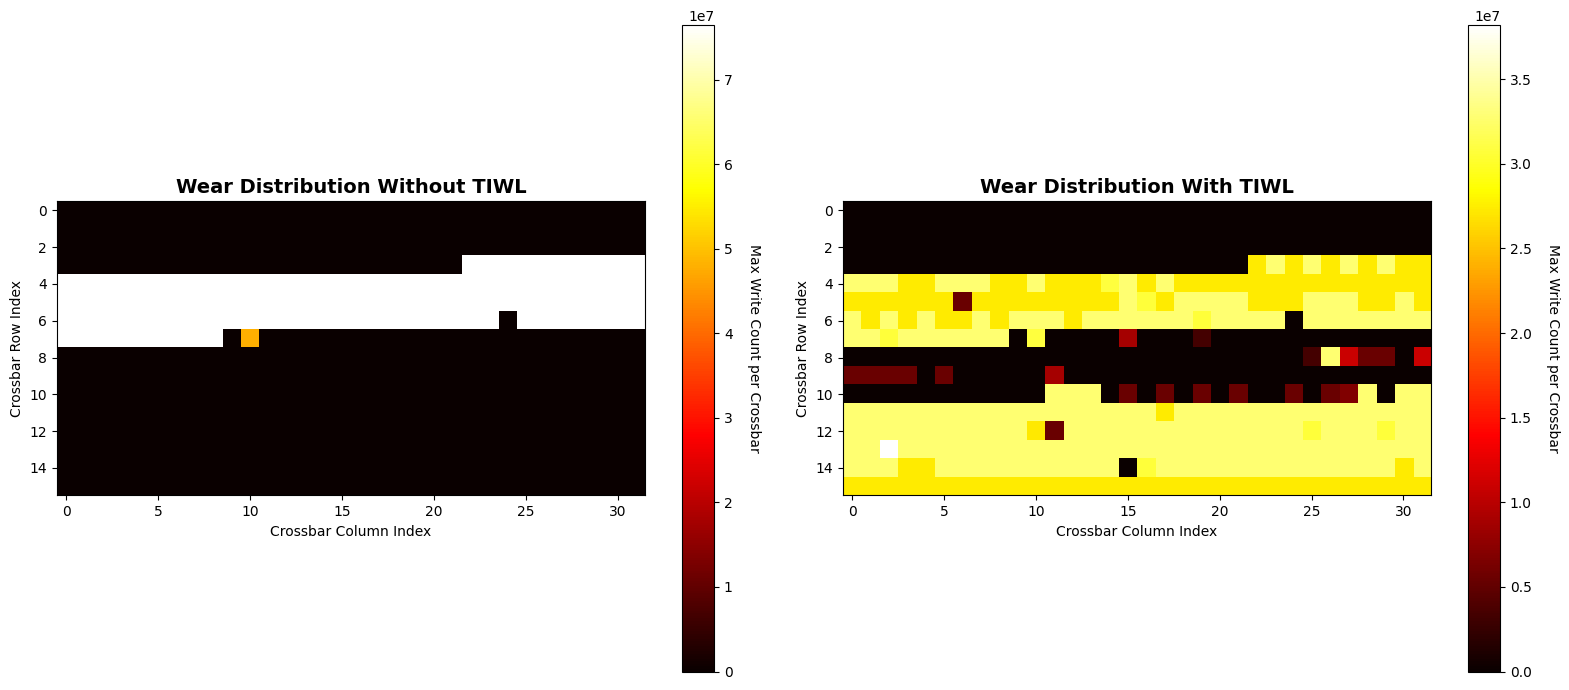

Without TIWL - Max: 76,464,128, Min: 0
With TIWL    - Max: 38,191,104, Min: 0
Wear reduction: 50.1%


In [17]:
plot_crossbar_wear_heatmap(pim_simulator_no_wear_levelling, pim_sim, grid_shape=(16, 32), save_path="heatmap.png")